In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
sns.set_style("darkgrid")

In [3]:
def split3(l):
    l1, l2 = train_test_split(l, test_size=0.66, random_state=42)
    l2, l3 = train_test_split(l2, test_size=0.5, random_state=42)
    return [l1, l2, l3]

In [4]:
file = pd.read_csv("data.csv")
columns = file.columns[8:15]
time_labels = [int(i.split("_")[1]) for i in columns]
bottom_limit = .665
top_limit = .71
train, test = train_test_split(file, test_size=0.2, random_state=42)
train_split3 = split3(train)

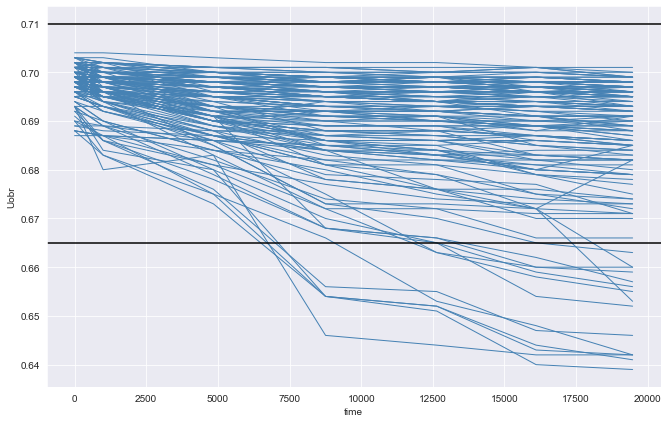

In [5]:
plt.figure(figsize=(11, 7))
for i in file[columns].iloc:
    data = np.array(i)
    plt.xlabel('time')
    plt.ylabel('Uobr')
    plt.plot(time_labels, data, color='steelblue', linewidth=1)
plt.axhline(y=bottom_limit, xmin=0, xmax=1, color='k', linewidth=1.5)
plt.axhline(y=top_limit, xmin=0, xmax=1, color='k', linewidth=1.5)

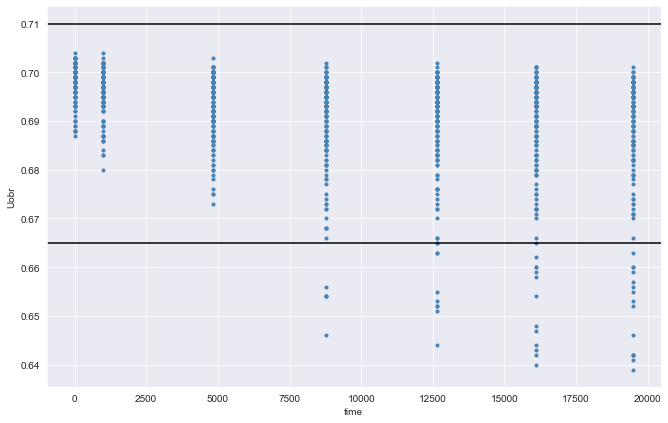

In [6]:
plt.figure(figsize=(11, 7))
for i in file[columns].iloc:
    data = np.array(i)
    plt.xlabel('time')
    plt.ylabel('Uobr')
    plt.scatter(time_labels, data, color='steelblue', marker=".")
plt.axhline(y=bottom_limit, xmin=0, xmax=1, color='k', linewidth=1.5)
plt.axhline(y=top_limit, xmin=0, xmax=1, color='k', linewidth=1.5)

In [7]:
weibull = sps.weibull_max
SHAPE = 1.5

In [8]:
linear_regression_x = []
loc = []
scale = []
for i in train_split3:
    train_mean0 = np.array(i[columns[0]]).mean()
    train_std0 = np.array(i[columns[0]]).std()
    for t, c in zip(time_labels, columns):
        linear_regression_x.append([t, train_mean0, train_std0])
        _shape, _loc, _scale = weibull.fit(i[c], fc=SHAPE)
        loc.append(_loc)
        scale.append(_scale)
linear_regression_x = np.array(linear_regression_x)

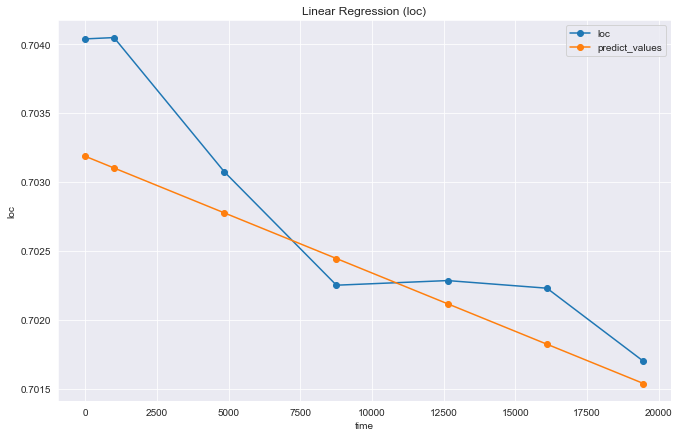

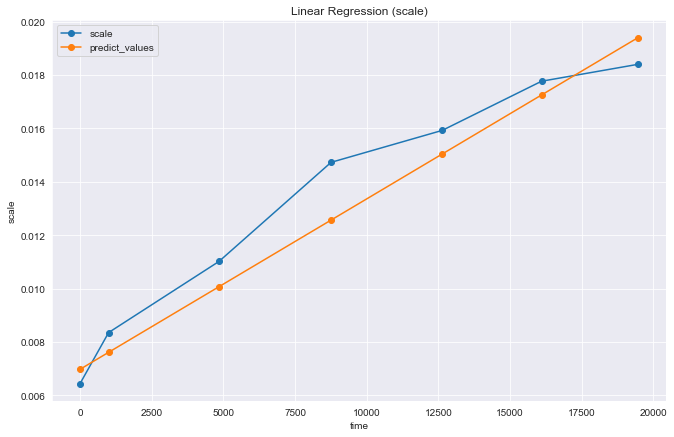

In [9]:
model_loc = LinearRegression()
model_loc.fit(linear_regression_x, loc)

model_scale = LinearRegression()
model_scale.fit(linear_regression_x, scale)

train_mean0 = np.array(train[columns[0]]).mean()
train_std0 = np.array(train[columns[0]]).std()
linear_regression_x_train = np.array([[i, train_mean0, train_std0] for i in time_labels])

plt.figure(figsize=(11, 7))
plt.title('Linear Regression (loc)')
plt.xlabel('time')
plt.ylabel('loc')
plt.plot(time_labels, [weibull.fit(train[i], fc=SHAPE)[1] for i in columns], label="loc", marker="o")
plt.plot(time_labels, model_loc.predict(linear_regression_x_train), label="predict_values", marker="o")
plt.legend()
plt.show()

plt.figure(figsize=(11, 7))
plt.title('Linear Regression (scale)')
plt.xlabel('time')
plt.ylabel('scale')
plt.plot(time_labels, [weibull.fit(train[i], fc=SHAPE)[2] for i in columns], label="scale", marker="o")
plt.plot(time_labels, model_scale.predict(linear_regression_x_train), label="predict_values", marker="o")
plt.legend()
plt.show()

In [10]:
test_mean0 = np.array(test[columns[0]]).mean()
test_std0 = np.array(test[columns[0]]).std()
linear_regression_x_test = np.array([[i, test_mean0, test_std0] for i in time_labels])
loc_test = model_loc.predict(linear_regression_x_test)
scale_test = model_scale.predict(linear_regression_x_test)

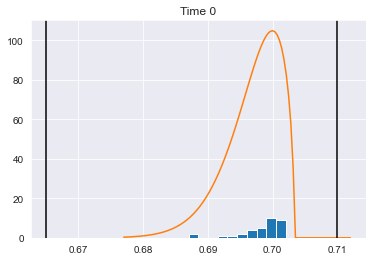

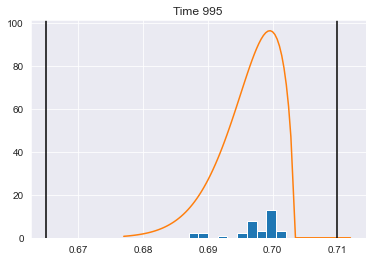

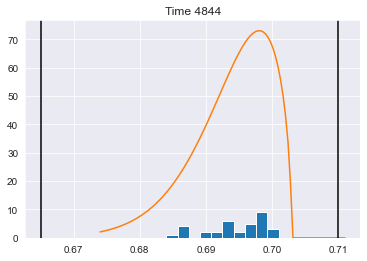

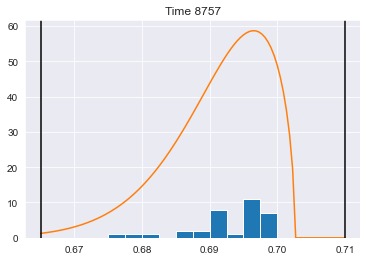

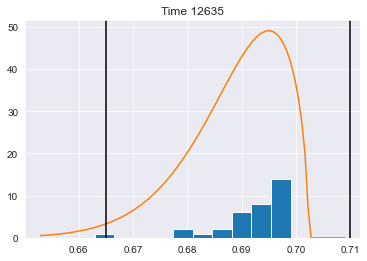

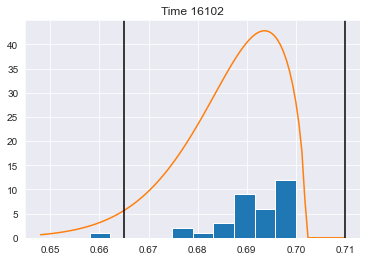

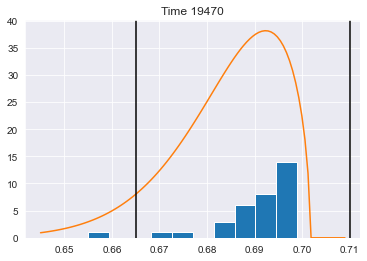

In [11]:
for i, j, k, l in zip(time_labels, columns, loc_test, scale_test):
    x = np.linspace(test[j].min() - 0.01, test[j].max() + 0.01, 100)
    plt.title(f'Time {i}')
    plt.hist(test[j])
    plt.plot(x, weibull(SHAPE, k, l).pdf(x))
    plt.axvline(bottom_limit, 0, 1, color='k')
    plt.axvline(top_limit, 0, 1, color='k')
    plt.show()

In [12]:
test_working_predict = []
for loc, scale in zip(loc_test, scale_test):
    top = weibull.cdf(x=top_limit, c=SHAPE, loc=loc, scale=scale)
    bottom = weibull.cdf(x=bottom_limit, c=SHAPE, loc=loc, scale=scale)
    test_working_predict.append(top - bottom)

In [13]:
test_working_experiment = []
for i in columns:
    working = 0
    for j in test[i]:
        if bottom_limit < j < top_limit:
            working += 1
    test_working_experiment.append(working / test.shape[0])

In [14]:
test_error = 0
for p, e in zip(test_working_predict, test_working_experiment):
    test_error += pow((p - e) / e, 2)
test_error = np.sqrt(test_error / len(test_working_predict))

In [15]:
print(f"Процент рабочих устройств:\n{'Время'.ljust(8)}{'Прогноз'.ljust(21)}Реальное значение")
for t, p, e in zip(time_labels, test_working_predict, test_working_experiment):
    print(f"{str(t).ljust(8)}{str(p).ljust(21)}{e}")
print(f"Ошибка: {test_error}")


Процент рабочих устройств:
Время   Прогноз              Реальное значение
0       0.999996386699649    1.0
995     0.9999830508192786   1.0
4844    0.9992336923676367   1.0
8757    0.9938898355542302   1.0
12635   0.9787593030152267   0.9705882352941176
16102   0.9551042069241983   0.9705882352941176
19470   0.9238839697230238   0.9705882352941176
Ошибка: 0.019562326732079444
